## RNN for Text Lecture Notes

1. Text Processing
2. Embeddings
3. LSTM network to classify recipes into cusines

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
    
sns.set_style('whitegrid')

from nltk.corpus import stopwords
from nltk import word_tokenize

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from keras_preprocessing.sequence import pad_sequences
from keras_preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.callbacks import ModelCheckpoint

%matplotlib inline 

Using TensorFlow backend.


## Dataset

Source: https://github.com/stevenjson/CuisineClassifying/tree/master/Data

We will be classifying recipes for 3 cuisines: French, Indian, Japanese

In [2]:
# the files are just lines with 1 recipes in each line, so we have to load them slightly differently from the usual pandas route
def file_to_array(path):
    '''Opens a file and returns lines as a numpy array'''
    with open(path, 'r') as f:
        result = f.readlines()
    return np.array(result)

In [3]:
french = file_to_array('./cuisine/french.txt')
japanese = file_to_array('./cuisine/japanese.txt')
indian = file_to_array('./cuisine/indian.txt')

In [10]:
japanese[1]

'1/2 cup sesame seeds 8 ounces dried soba noodles 2 tablespoons balsamic vinegar 1 tablespoon white sugar 2 1/2 tablespoons soy sauce 1 clove garlic , minced 1 teaspoon dark sesame oil 5 green onions , chopped 3 cups broccoli florets  | Preheat the oven to 375 degrees F (190 degrees C) . Pour the sesame seeds onto a rimmed baking sheet . Toast the seeds in the oven for 10 to 12 minutes , until they are a rich brown around the edges . Meanwhile , bring a large pot of salted water to a boil . Add the noodles and cook them for 5 to 6 minutes , or until they are just tender . Drain them , rinse them well with cold water , and drain them again . In a large mixing bowl , mix together the vinegar , sugar , soy sauce , garlic , sesame oil and green onions . Add the noodles , and the toasted sesame seeds . Toss well , then stir in the broccoli . Let the dish sit for 30 minutes at room temperature before serving . \n'

In [16]:
5*['hello']

['hello', 'hello', 'hello', 'hello', 'hello']

In [14]:
# how to create labels
len(french) * ['french']

['french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',
 'french',

In [17]:
# how to create a dataframe with receipes and cusine label
labels = len(french) * ['french']

pd.DataFrame({'recipe': french, 'cusine': labels}).head()

,recipe,cusine
0,1 cup all-purpose flour 5 eggs 1/4 cup milk 3/...,french
1,2 teaspoons olive oil 1 teaspoon butter 2 1/2 ...,french
2,"4 russet potatoes , sliced into 1/4 inch slice...",french
3,1 recipe pastry for a 9 inch single crust pie ...,french
4,2 teaspoons olive oil 1 teaspoon butter 2 1/2 ...,french


In [20]:
# concat all 3 cusines into 1 single dataframe

df = pd.concat([
    pd.DataFrame({'recipe': french, 'cusine':len(french) * ['french']}),
    pd.DataFrame({'recipe': japanese, 'cusine':len(japanese) * ['japanese']}),
    pd.DataFrame({'recipe': indian, 'cusine':len(indian) * ['indian']})
], axis=0) # axis=0 is by row 

# optionally reset index to 0 to 419
df.reset_index(inplace=True, drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 2 columns):
recipe    420 non-null object
cusine    420 non-null object
dtypes: object(2)
memory usage: 6.6+ KB


In [21]:
df['cusine'].value_counts()

french      180
japanese    120
indian      120
Name: cusine, dtype: int64

## Data Preprocessing

- Stopword removal
- Lemmatization, stemming (left as an exercise for you)
- Vectorization

In [22]:
def clean_stopwords(text):
    '''Remove stop words from a text'''
    stoplist = set(stopwords.words('english'))

    tokens = word_tokenize(text)
    
    # if lowercase of token is not in stoplist: (i.e. not a stopword)
    #    keep the token
    #
    # we keep only tokens that are not in the stopword list
    # ' '.join() creates a string out of a list
    return ' '.join([t for t in tokens if (t.lower() not in stoplist)])

In [23]:
#
# apply the clean_stopwords function on the 'recipe' column
#

# df['recipe'].apply(func) will apply func on every row
df['recipe'] = df['recipe'].apply(clean_stopwords)
df['recipe']

0      1 cup all-purpose flour 5 eggs 1/4 cup milk 3/...
1      2 teaspoons olive oil 1 teaspoon butter 2 1/2 ...
2      4 russet potatoes , sliced 1/4 inch slices 1 o...
3      1 recipe pastry 9 inch single crust pie 6 slic...
4      2 teaspoons olive oil 1 teaspoon butter 2 1/2 ...
5      1 clove garlic , halved 2 pounds potatoes , pe...
6      2 tablespoons all-purpose flour 1 1/2 cups uns...
7      1/2 cup semi-sweet chocolate chips 2 cups heav...
8      1/4 cup all-purpose flour 1 teaspoon salt 1/2 ...
9      2 cups heavy cream 3 tablespoons cultured butt...
10     4 onions , chopped 3 tablespoons butter 3 tabl...
11     6 bone-in , skin-on chicken thighs 1 pinch kos...
12     1 cup all-purpose flour 2 eggs 1/2 cup milk 1/...
13     1 pound chicken livers , trimmed 1 cup milk 8 ...
14     3 fresh eggs 1/4 teaspoon kosher salt 1/2 teas...
15     Stew : 1 tablespoon coarse sea salt , taste 1/...
16     1 ( 3 3 1/2 pound ) whole chicken 12 pearl oni...
17     Bouillabaisse : 1/2 cup 

### Vectorization

1) Tokenization to convert text to a sequence https://keras.io/preprocessing/text/

2) WordEmbeddings: create dense representation of the sequence

### Tokenizer

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

In [24]:
# Steps:
# 1. Initialise the Tokenizer with a max vocabulary size
# 2. fit_on_texts
# 3. text_to_sequences

max_words = 10000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['recipe'])

df['sequences'] = tokenizer.texts_to_sequences(df['recipe'])
df.head()

,recipe,cusine,sequences
0,1 cup all-purpose flour 5 eggs 1/4 cup milk 3/...,french,"[1, 3, 119, 120, 33, 36, 81, 1, 7, 3, 60, 8, 7..."
1,2 teaspoons olive oil 1 teaspoon butter 2 1/2 ...,french,"[2, 37, 90, 12, 1, 6, 32, 2, 1, 2, 13, 511, 11..."
2,"4 russet potatoes , sliced 1/4 inch slices 1 o...",french,"[7, 869, 112, 58, 1, 7, 55, 100, 1, 23, 58, 75..."
3,1 recipe pastry 9 inch single crust pie 6 slic...,french,"[1, 965, 221, 361, 55, 705, 404, 405, 71, 100,..."
4,2 teaspoons olive oil 1 teaspoon butter 2 1/2 ...,french,"[2, 37, 90, 12, 1, 6, 32, 2, 1, 2, 13, 511, 11..."


In [27]:
# show the vocabulary (index <-> word mapping)
tokenizer.word_index

{'1': 1,
 '2': 2,
 'cup': 3,
 'minutes': 4,
 'heat': 5,
 'teaspoon': 6,
 '4': 7,
 '3': 8,
 'salt': 9,
 'stir': 10,
 'chicken': 11,
 'oil': 12,
 'tablespoons': 13,
 'pepper': 14,
 'cook': 15,
 'water': 16,
 'medium': 17,
 'tablespoon': 18,
 'sugar': 19,
 'skillet': 20,
 'add': 21,
 'sauce': 22,
 'onion': 23,
 'degrees': 24,
 'large': 25,
 'place': 26,
 'garlic': 27,
 'chopped': 28,
 'ground': 29,
 'bowl': 30,
 'mixture': 31,
 'butter': 32,
 'flour': 33,
 'oven': 34,
 'cups': 35,
 '5': 36,
 'teaspoons': 37,
 'cover': 38,
 'rice': 39,
 'white': 40,
 'fresh': 41,
 '10': 42,
 'pour': 43,
 'ginger': 44,
 'powder': 45,
 'taste': 46,
 'mix': 47,
 'simmer': 48,
 'cheese': 49,
 'together': 50,
 'cream': 51,
 'ounce': 52,
 'egg': 53,
 'pan': 54,
 'inch': 55,
 'high': 56,
 'remove': 57,
 'sliced': 58,
 'f': 59,
 'milk': 60,
 'c': 61,
 'cut': 62,
 'onions': 63,
 'brown': 64,
 'dough': 65,
 'black': 66,
 'bring': 67,
 'wine': 68,
 'baking': 69,
 'paste': 70,
 '6': 71,
 'soy': 72,
 'low': 73,
 'top':

In [28]:
# actual vocabulary size
len(tokenizer.word_index)

2190

### Embeddings

Steps to use Embeddings:
1. Make sure all sequences are the same length. We need to pick a fixed sequence length.
    Options:
     - pick the max, pad the rest 
     - pick the some N, truncate text longer than N, pad text shorter than N.
     
2. Create an Embedding layer as the first layer of your Neural Network
3. Pass the sequence (not the text) directly to the Embedding layer

#### Padding Sequences

All sequences need to be the same length

Options:
 - pick the max length. All shorter sequences will be padding
 - pick N < max, truncate sequences longer than N, pad sequences shorter than N.
 
Notable settings:
 - pre-padding or post-padding. Most select 'pre' padding so that the output hidden state does not go to zero (intuition: https://stackoverflow.com/questions/46298793/how-does-choosing-between-pre-and-post-zero-padding-of-sequences-impact-results)
 - the value to use for padding. Default is 0, which maps to no word.

In [39]:
# pad_sequences?

In [35]:
# len(pad_sequences(df['sequences'])[2]), len(df['sequences'][2])

In [38]:
# you can specify a maximum length, which will truncate sequences longer it
# pad_sequences(df['sequences'], maxlen=400, padding='post')
pad_sequences(df['sequences'], maxlen=400)

array([[   0,    0,    0, ...,  416,  809,   19],
       [   0,    0,    0, ...,  209,  101,   88],
       [   0,    0,    0, ...,  145,  114,   34],
       ...,
       [   0,    0,    0, ...,  102,    4,  151],
       [   0,    0,    0, ...,    4,  229,   89],
       [   0,    0,    0, ...,  735, 1543,   46]])

In [40]:
X = pad_sequences(df['sequences'])

In [41]:
X.shape

(420, 458)

In [43]:
# to_categorical expects numbers, not strings
le = LabelEncoder()
y_encoded = le.fit_transform(df['cusine'])
y = to_categorical(y_encoded) # multi-class, need to_categorical

In [44]:
y.shape

(420, 3)

In [46]:
le.classes_

array(['french', 'indian', 'japanese'], dtype=object)

In [45]:
y

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

#### Train-test-split

Consider: why do we not care about shuffling here?

What is the difference between this and time series?

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [48]:
X_train

array([[   0,    0,    0, ...,  204,   10,  422],
       [   0,    0,    0, ...,  237,   28,  141],
       [   0,    0,    0, ...,  101, 2064,  731],
       ...,
       [   0,    0,    0, ...,  134,   64,   89],
       [   0,    0,    0, ...,  124,  159,  101],
       [   0,    0,    0, ...,  137, 1504, 1015]])

### Model

Good explanation (as usual) from: https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

The Embedding layer is defined as the first hidden layer of a network. It must specify 3 arguments:

- input_dim: This is the size of the vocabulary in the text data. For example, if your data is integer encoded to values between 0-10, then the size of the vocabulary would be 11 words.


- output_dim: This is the size of the vector space in which words will be embedded. It defines the size of the output vectors from this layer for each word. For example, it could be 32 or 100 or even larger. Test different values for your problem.


- input_length: This is the length of input sequences, as you would define for any input layer of a Keras model. For example, if all of your input documents are comprised of 1000 words, this would be 1000.

In [53]:
len(tokenizer.word_index) # vocab (2190 unique words)

2190

In [52]:
X_train.shape # 315 is number of rows (recipes), 458 sequence length (recipe length)

(315, 458)

In [57]:
# vocabulary: remember to add 1 for the padding token (0)
# tokenizer.word_index excludes 0
# Embedding layer needs to know about 0, and the 2190 vocab index
# New words not found in training set will be ignored
input_dim = len(tokenizer.word_index) + 1

# output of the embedding layer
# compress my 2191 vocab (one-hot) recipe into 100-sized vector
# Each recipe is 458 long, can be any of 2191 vocab
#
# 458 x 2191 is a sparse matrix
# Embedding will output a tensor of 458x100
# use as input directly into LSTM
#
output_dim = 100

# length of the sequence
input_length = X.shape[1] # sequence length
                          # X.shape returns (rows, cols)
                          # X.shape[1] returns cols

In [56]:
# example
Embedding(input_dim, output_dim, input_length=input_length)

# Party Time!

Model architecture:
1. Embedding with the above settings (must be first layer)
2. LSTM
3. Dense MLP with the appropriate activation type and the correct number of output classes
4. Compile the model
5. Fit it using X_train, y_train. Validate using X_test, y_test. Optionally set callbacks, etc.
6. Evaluate metrics

Notes:
- You may refer to https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/ for an example
- This model may train quite slowly, may want to try only 10-20 epochs at time. You can always call fit multiple times.
- Feel free to experiment with stacked LSTM, multiple Dense layers, etc

In [58]:
# define your model, compile, and fit it (10-15 epochs should be enough for a decent model)

model = Sequential()
model.add(Embedding(input_dim, output_dim, input_length=input_length))

model.add(LSTM(256))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 458, 100)          219100    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               365568    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 99        
Total params: 592,991
Trainable params: 592,991
Non-trainable params: 0
_________________________________________________________________


In [59]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [60]:
mc = ModelCheckpoint('./cusines_lstm.h5', save_best_only=True)

In [61]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), callbacks=[mc], epochs=10)

Instructions for updating:
Use tf.cast instead.
Train on 315 samples, validate on 105 samples
Epoch 1/10
315/315 [==============================] - 45s 143ms/step - loss: 1.0951 - acc: 0.4381 - val_loss: 1.0686 - val_acc: 0.3905
Epoch 2/10
315/315 [==============================] - 12s 37ms/step - loss: 1.0143 - acc: 0.5365 - val_loss: 1.0138 - val_acc: 0.5905
Epoch 3/10
315/315 [==============================] - 14s 45ms/step - loss: 0.8186 - acc: 0.6540 - val_loss: 0.8250 - val_acc: 0.6190
Epoch 4/10
315/315 [==============================] - 12s 38ms/step - loss: 0.6283 - acc: 0.7619 - val_loss: 0.6905 - val_acc: 0.7143
Epoch 5/10
315/315 [==============================] - 12s 38ms/step - loss: 0.3506 - acc: 0.9238 - val_loss: 0.8002 - val_acc: 0.7619
Epoch 6/10
315/315 [==============================] - 13s 41ms/step - loss: 0.2269 - acc: 0.9492 - val_loss: 0.6005 - val_acc: 0.7810
Epoch 7/10
315/315 [==============================] - 13s 41ms/step - loss: 0.1270 - acc: 0.9429 - va

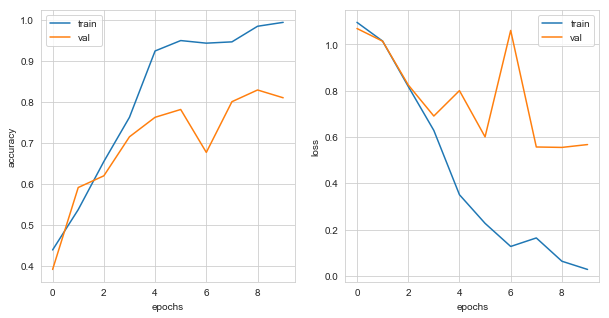

In [62]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

ax[0].plot(history.history['acc'], label='train')
ax[0].plot(history.history['val_acc'], label='val')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epochs')
ax[0].legend()

ax[1].plot(history.history['loss'], label='train')
ax[1].plot(history.history['val_loss'], label='val')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epochs')
ax[1].legend()

plt.show()


## Metrics

In [63]:
pred = model.predict_classes(X_test)

In [64]:
confusion_matrix(y_test.argmax(axis=1), pred)

array([[35,  3,  3],
       [ 4, 28,  3],
       [ 6,  1, 22]], dtype=int64)

In [65]:
print(classification_report(y_test.argmax(axis=1), pred))

              precision    recall  f1-score   support

           0       0.78      0.85      0.81        41
           1       0.88      0.80      0.84        35
           2       0.79      0.76      0.77        29

    accuracy                           0.81       105
   macro avg       0.81      0.80      0.81       105
weighted avg       0.81      0.81      0.81       105



In [66]:
X_test

array([[  0,   0,   0, ...,  34, 278,   4],
       [  0,   0,   0, ...,  71, 274, 145],
       [  0,   0,   0, ..., 141, 101,  83],
       ...,
       [  0,   0,   0, ...,  55, 206, 100],
       [  0,   0,   0, ..., 549, 945, 135],
       [  0,   0,   0, ..., 438, 171,  33]])

## Predictions using real recipes

Try your model against these sample recipes from various websites

In [67]:
# https://www.epicurious.com/recipes/food/views/miso-soup-103391

recipe = '''
1/2 cup dried wakame (a type of seaweed)
1/4 cup shiro miso (white fermented-soybean paste)
6 cups Dashi.
1/2 pound soft tofu, drained and cut into 1/2-inch cubes.
1/4 cup thinly sliced scallion greens.
Stir together miso and 1/2 cup dashi in a bowl until smooth. Heat remaining dashi in a saucepan over moderately high heat until hot, then gently stir in tofu and reconstituted wakame. Simmer 1 minute and remove from heat. Immediately stir in miso mixture and scallion greens and serve.
'''

clean_stopwords(recipe)
recipe_input = tokenizer.texts_to_sequences([clean_stopwords(recipe)])
recipe_input_padded = pad_sequences(recipe_input, maxlen=input_length)
le.inverse_transform(model.predict_classes(recipe_input_padded))

array(['japanese'], dtype=object)

In [72]:
# https://recipes.timesofindia.com/recipes/masala-chicken/rs54673639.cms

recipe = '''
1 1/4 kilograms washed & dried chicken
3 cup sliced onion
2 cup minced tomato
1 cup finely chopped coriander leaves
1 tablespoon garlic flakes
1 teaspoon cumin seeds
1 tablespoon chilli powder
1/2 teaspoon powdered turmeric
1/2 cup grated coconut
5 tablespoon refined oil
1/2 cup curry leaves
1 teaspoon salt
2 inches ginger
3/4 teaspoon mustard seeds
1 teaspoon peppercorns
3 tablespoon coriander powder
3/4 cup water
1 1/2 tablespoon poppy seeds

Step 1- Soak the chicken in lukewarm water to reduce the cooking time
Masala Chicken is one of the most delicious non-veg preparations. Made with some easily available ingredients. It might look difficult to prepare, but we have found the easiest recipe to prepare this amazing delicacy. Here’s how you can cook it, in the restaurant style at the convenience of your home. Soak the chicken pieces in some lukewarm water with a small pinch of salt, this will reduce the time required to cook the chicken and will make the pieces soft & tender. Then, clean and rinse the pieces properly.

Step 2- Make a paste of all the spices and a fresh coconut paste
Keep this cleaned chicken aside and make a paste of 2 pieces of ginger, garlic, mustard seeds, cumin seeds, and black peppercorn. Then take chilli powder, coriander powder, turmeric powder and a quarter cup of water. Grind them all and make a paste of it. Now, grind together grated fresh coconut and poppy seeds and make a fine paste of them.

Step 3- Cook the chicken with the spices paste and onions
Heat oil in a pressure cooker, fry onions till they turn golden brown. Then add curry leaves and salt, mix in the ginger-garlic spice paste and fry for three minutes. Now add chilli-coriander-turmeric powder paste. Mix thoroughly and add the chicken pieces. Fry for five minutes.

Step 4- Cook the chicken with coconut-poppy paste and tomatoes, and serve hot
Add tomatoes and fry for another five minutes with one and a half cups of water and cook for about 10-15 minutes. When the chicken is tender, mix in the coconut-poppy seed paste and cook over medium heat for five minutes. Finally, add coriander leaves, mix well and remove from heat. Serve hot with butter naan and raita. mutton mutton mutton
'''

clean_stopwords(recipe)
recipe_input = tokenizer.texts_to_sequences([clean_stopwords(recipe)])
recipe_input_padded = pad_sequences(recipe_input, maxlen=input_length)
le.inverse_transform(model.predict_classes(recipe_input_padded))

array(['indian'], dtype=object)

In [73]:
# not in the vocab
tokenizer.word_index['mutton']

KeyError: 'mutton'

In [71]:
tokenizer.word_index['chicken']

11